In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from itertools import chain
import random
import cv2
from glob import glob
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Lambda, Conv2D, Conv2DTranspose,MaxPooling2D, concatenate,UpSampling2D,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
patient = []
for i in os.listdir('../data/lgg-mri-segmentation/kaggle_3m/'):
    if i!= 'data.csv' and i!='README.md' :
        patient.append(i)

In [3]:
def create_dataset(start,end,dataset_type):
    train_files = []
    mask_files=[]
    c=0
    for i,p in enumerate(patient[start:end]):
        vals=[]
        mask_files.append(glob('../data/lgg-mri-segmentation/kaggle_3m/'+p+'/*_mask*'))
        for m in mask_files[i]:
            vals.append(np.max(cv2.imread(m)))
        if max(vals)==0:
            print(f'patient { p } has no tumor')
            c+=1
    if c==0:
        print(f'Each patient in {dataset_type} dataset has brain tumor')
    mask_files=list(chain.from_iterable(mask_files))
    for m in mask_files:
        train_files.append(m.replace('_mask',''))
    df = pd.DataFrame(data={"filepath": train_files, 'mask' : mask_files})
    return df

In [4]:
# 트레인 데이터, 테스트 데이터, 검증 데이터의 길이
a = int(0.9*len(patient))
b = int(0.8*a)


In [5]:
# 주어진 데이터에서 있는 환자중에서 있는 환자가 없는 환자를 찾아봅니다.
df_train=create_dataset(0,b,'training')
df_val=create_dataset(b,a,'validation')
df_test=create_dataset(a,len(patient),'testing')

Each patient in training dataset has brain tumor
Each patient in validation dataset has brain tumor
Each patient in testing dataset has brain tumor


In [7]:
#기능 : 이미지의 픽셀 범위를 보는 함수. 메모 : 이 함수는 매번 호출될 때 랜덤한 이미지를 선택합니다.
def pixel_value_counts(col, end):
    p = np.random.randint(0, end)
    img = cv2.imread(df_train[col].loc[p])
    unique, counts = np.unique(img, return_counts=True)
    print(f'showing pixel value counts for image {p}')
    print(np.asarray((unique, counts)).T)

# pixel_value_counts('filepath',len(df_train)) 테스트 및 검증 셋에서 픽셀 값의 카운트를 보여줍니다.
pixel_value_counts('mask',len(df_train))

showing pixel value counts for image 582
[[     0 183498]
 [   255  13110]]


In [8]:
#마스크를 테스트 데이터에서 0과 1으로 표시합니다. 이것은 프로젝트를 마치기 전에 유용합니다.
for i in range(0,len(df_test)):
    arr = np.where(cv2.imread(df_test['mask'].loc[i])==255,1,0)
    v = np.max(arr)
    if v==1:
        df_test.loc[i,'res'] = 1
    else:
        df_test.loc[i,'res'] = 0

In [9]:
df_train.sample(5,random_state=42)

,filepath,mask
2411,../data/lgg-mri-segmentation/kaggle_3m/TCGA_FG...,../data/lgg-mri-segmentation/kaggle_3m/TCGA_FG...
1547,../data/lgg-mri-segmentation/kaggle_3m/TCGA_DU...,../data/lgg-mri-segmentation/kaggle_3m/TCGA_DU...
881,../data/lgg-mri-segmentation/kaggle_3m/TCGA_DU...,../data/lgg-mri-segmentation/kaggle_3m/TCGA_DU...
331,../data/lgg-mri-segmentation/kaggle_3m/TCGA_CS...,../data/lgg-mri-segmentation/kaggle_3m/TCGA_CS...
1837,../data/lgg-mri-segmentation/kaggle_3m/TCGA_DU...,../data/lgg-mri-segmentation/kaggle_3m/TCGA_DU...


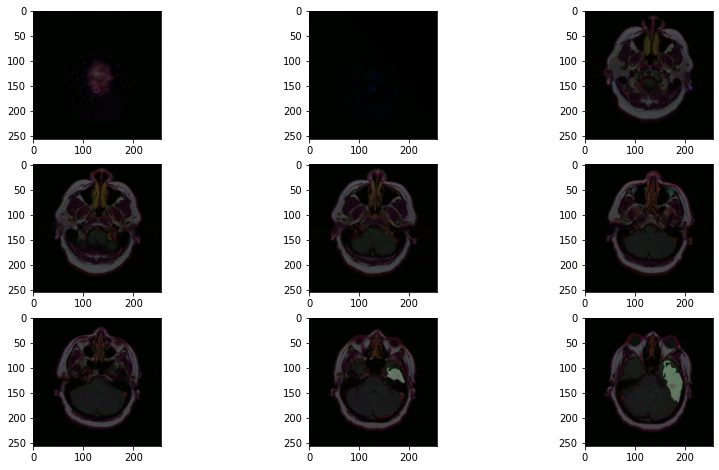

In [10]:
# 랜덤 환자에 대한 MRI 스캔 이미지를 보여줍니다.
f,ax=plt.subplots(3,3,figsize=(14,8))
ax=ax.flatten()
for j in range(0,9):
    i=1453+j
    img=cv2.imread(df_train['filepath'].loc[i])
    msk=cv2.imread(df_train['mask'].loc[i])
    ax[j].imshow(msk)
    ax[j].imshow(img,alpha=0.7)
plt.show()

In [11]:
#데이터 생성
def img_dataset(df_inp, path_img, path_mask, aug_args, batch) :
    img_gen = ImageDataGenerator(rescale=1./255., **aug_args)
    df_img = img_gen.flow_from_dataframe(dataframe=df_inp,
                                            x_col=path_img,
                                            class_mode = None,
                                            batch_size=batch,
                                            color_mode='rgb',
                                            seed = 1,
                                            target_size = (256,256))

    df_mask = img_gen.flow_from_dataframe(dataframe=df_inp,
                                            x_col = path_mask,
                                            class_mode = None,
                                            batch_size=batch,
                                            color_mode='grayscale',
                                            seed = 1,
                                            target_size = (256,256))
    data_gen = zip(df_img, df_mask)
    return data_gen

In [12]:
# 손실 함수
def dice_loss(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersec = K.sum(y_true * y_pred)
    return (-((2* intersec + 0.1) / (K.sum(y_true) + K.sum(y_pred) + 0.1)))

def iou(y_true, y_pred):
    intersec = K.sum(y_true * y_pred)
    union = K.sum(y_true + y_pred)
    iou = (intersec + 0.1) / (union - intersec + 0.1)
    return iou

In [13]:
def conv_block(inp,filters):
    x=Conv2D(filters,(3,3),padding='same',activation='relu')(inp)
    x=Conv2D(filters,(3,3),padding='same')(x)
    x=BatchNormalization(axis=3)(x)
    x=Activation('relu')(x)
    return x

def encoder_block(inp,filters):
    x=conv_block(inp,filters)
    p=MaxPooling2D(pool_size=(2,2))(x)
    return x,p

def attention_block(l_layer,h_layer): #Attention Block
    phi=Conv2D(h_layer.shape[-1],(1,1),padding='same')(l_layer)
    theta=Conv2D(h_layer.shape[-1],(1,1),strides=(2,2),padding='same')(h_layer)
    x=tf.keras.layers.add([phi,theta])
    x=Activation('relu')(x)
    x=Conv2D(1,(1,1),padding='same',activation='sigmoid')(x)
    x=UpSampling2D(size=(2,2))(x)
    x=tf.keras.layers.multiply([h_layer,x])
    x=BatchNormalization(axis=3)(x)
    return x
    
def decoder_block(inp,filters,concat_layer):
    x=Conv2DTranspose(filters,(2,2),strides=(2,2),padding='same')(inp)
    concat_layer=attention_block(inp,concat_layer)
    x=concatenate([x,concat_layer])
    x=conv_block(x,filters)
    return x

In [14]:
inputs=Input((256,256,3))
d1,p1=encoder_block(inputs,64)
d2,p2=encoder_block(p1,128)
d3,p3=encoder_block(p2,256)
d4,p4=encoder_block(p3,512)
b1=conv_block(p4,1024)
e2=decoder_block(b1,512,d4)
e3=decoder_block(e2,256,d3)
e4=decoder_block(e3,128,d2)
e5=decoder_block(e4,64,d1)
outputs = Conv2D(1, (1,1),activation="sigmoid")(e5)
model=Model(inputs=[inputs], outputs=[outputs],name='AttnetionUnet')

In [15]:
model.summary()

Model: "AttnetionUnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                     

In [16]:
# 훈련 세트에 대한 데이터 증대 작업 수행
augmentation_args = dict(rotation_range = 0.2,
                         width_shift_range = 0.05,
                        height_shift_range = 0.05,
                        shear_range = 0.05,
                        zoom_range = 0.05,
                        fill_mode = 'nearest')

batch = 32

In [17]:
def train_model(model, save_name, loss_func):
    opt = Adam(learning_rate = 1e-4, epsilon = None, amsgrad = False, beta_1 = 0.9, beta_2 = 0.99)
    model.compile(optimizer = opt, loss = loss_func, metrics = [iou])
    callbacks = [ModelCheckpoint(save_name, verbose = 1, save_best_only = True),
                 ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, verbose = 1, patience = 5, min_lr = 1e-6),
                 EarlyStopping(monitor = 'val_loss', patience = 15, restore_best_weights=True)]
    train = img_dataset(df_train, 'filepath', 'mask', augmentation_args, batch)
    val = img_dataset(df_val, 'filepath', 'mask', dict(), batch)


    history = model.fit_generator(train,
                                    validation_data = val,
                                    steps_per_epoch = len(df_train)/batch,
                                    validation_steps = len(df_val)/batch,
                                    epochs = 3,
                                    callbacks = callbacks)


    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.title("Training Loss Curve")
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

Found 2984 validated image filenames.
Found 2984 validated image filenames.
Found 547 validated image filenames.
Found 547 validated image filenames.


C:\Users\JYP\AppData\Local\Temp\ipykernel_23716\1456352047.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train,


Epoch 1/3
94/93 [==============================] - ETA: -33s - loss: nan - iou: nan
Epoch 1: val_loss did not improve from inf
93/93 [==============================] - 4373s 47s/step - loss: nan - iou: nan - val_loss: nan - val_iou: nan - lr: 1.0000e-04
Epoch 2/3
94/93 [==============================] - ETA: -34s - loss: nan - iou: nan
Epoch 2: val_loss did not improve from inf
93/93 [==============================] - 4533s 49s/step - loss: nan - iou: nan - val_loss: nan - val_iou: nan - lr: 1.0000e-04
Epoch 3/3
94/93 [==============================] - ETA: -32s - loss: nan - iou: nan
Epoch 3: val_loss did not improve from inf
93/93 [==============================] - 4283s 46s/step - loss: nan - iou: nan - val_loss: nan - val_iou: nan - lr: 1.0000e-04


AttributeError: module 'matplotlib.pyplot' has no attribute 'tile'

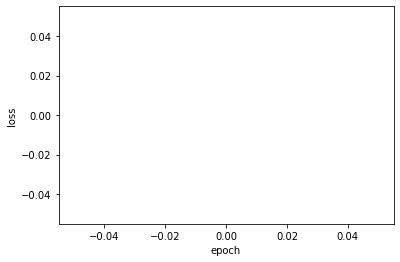

In [18]:
train_model(model, 'unet_wts1.hdf5', dice_loss)

In [1]:
# 평가

def eval_model(model_wts,custom_objects):
    model = load_model(model_wts,custom_objects=custom_objects)
    test=img_dataset(df_test[['filepath','mask']],'filepath','mask',dict(),32)
    model.evaluate(test,steps=len(df_test)/32)
    a=np.random.RandomState(seed=42)
    indexes=a.randint(1,len(df_test[df_test['res']==1]),10)
    for i in indexes:
        img = cv2.imread(df_test[df_test['res']==1].reset_index().loc[i,'filepath'])
        img = cv2.resize(img ,(256, 256))
        img = img / 255
        img = img[np.newaxis, :, :, :]
        pred=model.predict(img)

        plt.figure(figsize=(12,12))
        plt.subplot(1,3,1)
        plt.imshow(np.squeeze(img))
        plt.title('Original Image')
        plt.subplot(1,3,2)
        plt.imshow(np.squeeze(cv2.imread(df_test[df_test['res']==1].reset_index().loc[i,'mask'])))
        plt.title('Original Mask')
        plt.subplot(1,3,3)
        plt.imshow(np.squeeze(pred) > .5)
        plt.title('Prediction')
        plt.show()

eval_model('unet_wts1.hdf5',{'dice_loss':dice_loss,'iou':iou})

NameError: name 'dice_loss' is not defined